<a href="https://colab.research.google.com/github/Subin-pds/Machine-Learning-Practice-Projects/blob/main/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vehicle-dataset-from-cardekho:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F33080%2F1584391%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T051448Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D46b86c2564f27074f5038faa87e743f092cf719e80209c653a37951099393148928f7893659b85601504a3e36157a5732214c8208b6ad183267029e855f39ad84a40f51ca7e01b15c0120741f16e328dd7c6b07905c55976a0376650bc4733e797f0754da1dc89afcd6c18602b70708f066e9ffd3c1bd38d982fdd193636412cb09658cbaa7019894958884d2d82039cb1db44b418b08ff788be7152c1fbf6a2fa74c2f6dcacaa1bf568cad7a8a29b584b8d9c0a33c8f2fdaa73c03940719c1559f6ef438eff131e36d5a002ad3f4c963d5950d9bfb2cc12ab57599efb6db6c715917e149d669226ed9c50081787f22530eb53cde63eb38668aea35005fbdb85'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 232627 bytes downloaded
Downloaded and uncompressed: vehicle-dataset-from-cardekho
Data source import complete.


### Reading and Understanding the Dataset

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

%matplotlib inline
pd.set_option("display.max_rows", None,"display.max_columns", None)
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')

In [3]:
#load dataset
df_main = pd.read_csv('../input/vehicle-dataset-from-cardekho/car data.csv')

In [4]:
df_main.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [5]:
df_main.shape

(301, 9)

In [6]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [7]:
#numerical stats
df_main.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [8]:
#missing values
df_main.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

### Data Preprocessing

In [9]:
df_main['Age'] = 2020 - df_main['Year']
df_main.drop('Year',axis=1,inplace = True)

In [10]:
df_main.rename(columns = {'Selling_Price':'Selling_Price(lacs)','Present_Price':'Present_Price(lacs)','Owner':'Past_Owners'},inplace = True)

### Exploratory Data Analysis (EDA)

#### Univariate Analysis

In [11]:
df_main.columns

Index(['Car_Name', 'Selling_Price(lacs)', 'Present_Price(lacs)', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Past_Owners', 'Age'],
      dtype='object')

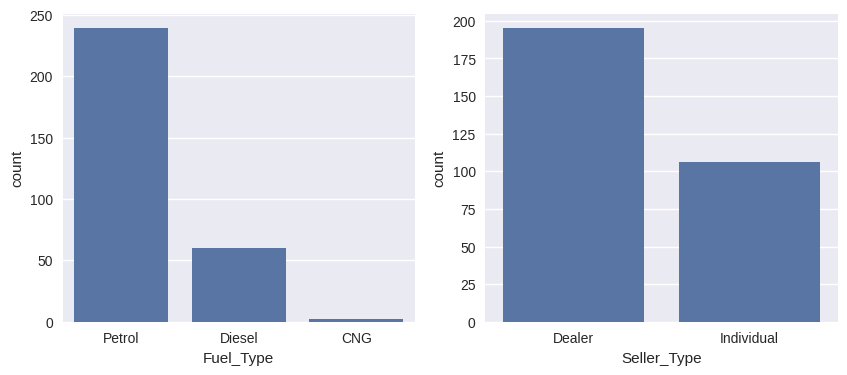

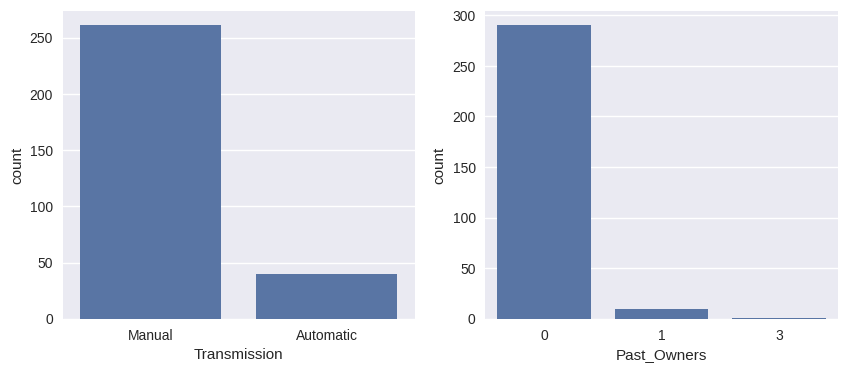

In [12]:
cat_cols = ['Fuel_Type','Seller_Type','Transmission','Past_Owners']
i=0
while i < 4:
    fig = plt.figure(figsize=[10,4])
    #ax1 = fig.add_subplot(121)
    #ax2 = fig.add_subplot(122)

    #ax1.title.set_text(cat_cols[i])
    plt.subplot(1,2,1)
    sns.countplot(x=cat_cols[i], data=df_main)
    i += 1

    #ax2.title.set_text(cat_cols[i])
    plt.subplot(1,2,2)
    sns.countplot(x=cat_cols[i], data=df_main)
    i += 1

    plt.show()

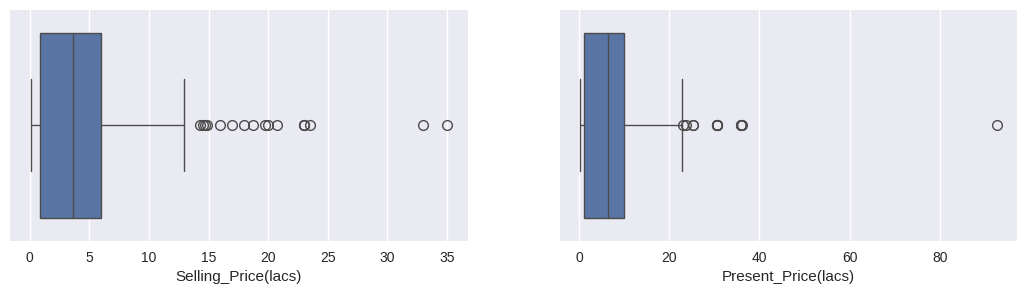

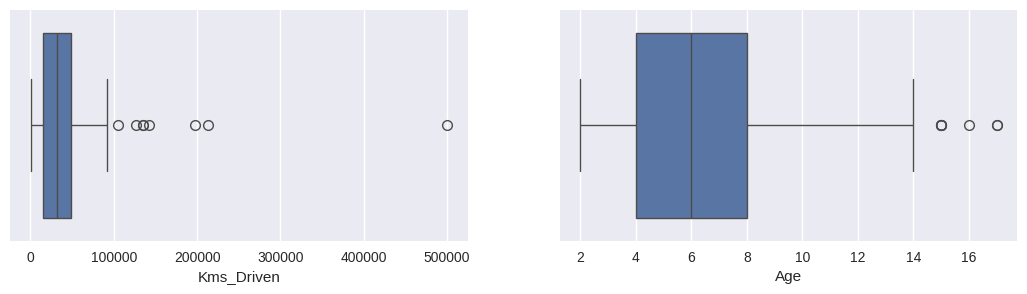

In [13]:
num_cols = ['Selling_Price(lacs)','Present_Price(lacs)','Kms_Driven','Age']
i=0
while i < 4:
    fig = plt.figure(figsize=[13,3])
    #ax1 = fig.add_subplot(121)
    #ax2 = fig.add_subplot(122)

    #ax1.title.set_text(num_cols[i])
    plt.subplot(1,2,1)
    sns.boxplot(x=num_cols[i], data=df_main)
    i += 1

    #ax2.title.set_text(num_cols[i])
    plt.subplot(1,2,2)
    sns.boxplot(x=num_cols[i], data=df_main)
    i += 1

    plt.show()

In [14]:
df_main[df_main['Present_Price(lacs)'] > df_main['Present_Price(lacs)'].quantile(0.99)]

,Car_Name,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Fuel_Type,Seller_Type,Transmission,Past_Owners,Age
64,fortuner,33.0,36.23,6000,Diesel,Dealer,Automatic,0,3
86,land cruiser,35.0,92.60,78000,Diesel,Dealer,Manual,0,10


In [15]:
df_main[df_main['Selling_Price(lacs)'] > df_main['Selling_Price(lacs)'].quantile(0.99)]

,Car_Name,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Fuel_Type,Seller_Type,Transmission,Past_Owners,Age
63,fortuner,23.5,35.96,47000,Diesel,Dealer,Automatic,0,5
64,fortuner,33.0,36.23,6000,Diesel,Dealer,Automatic,0,3
86,land cruiser,35.0,92.60,78000,Diesel,Dealer,Manual,0,10


In [16]:
df_main[df_main['Kms_Driven'] > df_main['Kms_Driven'].quantile(0.99)]

,Car_Name,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Fuel_Type,Seller_Type,Transmission,Past_Owners,Age
84,innova,3.49,13.46,197176,Diesel,Dealer,Manual,0,15
179,Honda Karizma,0.31,1.05,213000,Petrol,Individual,Manual,0,10
196,Activa 3g,0.17,0.52,500000,Petrol,Individual,Automatic,0,12


#### Bivariate/Multi-Variate Analysis

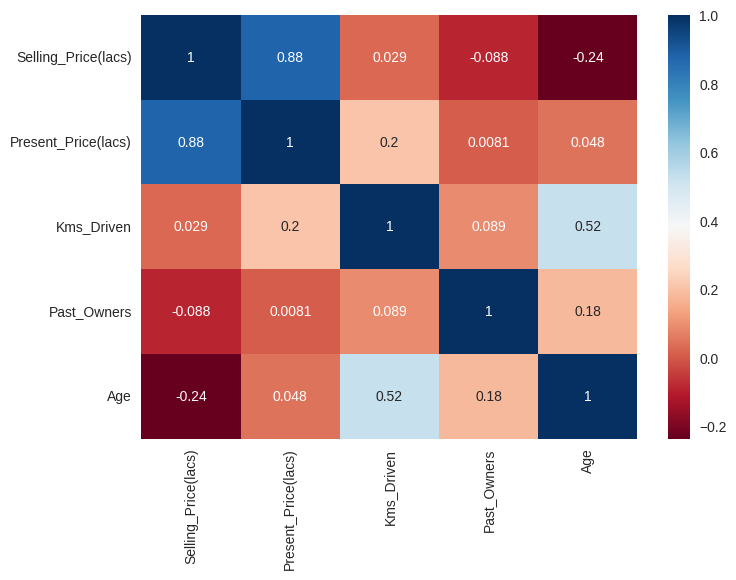

In [17]:
sns.heatmap(df_main.corr(), annot=True, cmap="RdBu")
plt.show()

In [18]:
df_main.corr()['Selling_Price(lacs)']

Selling_Price(lacs)    1.000000
Present_Price(lacs)    0.878983
Kms_Driven             0.029187
Past_Owners           -0.088344
Age                   -0.236141
Name: Selling_Price(lacs), dtype: float64

In [19]:
df_main.pivot_table(values='Selling_Price(lacs)', index = 'Seller_Type', columns= 'Fuel_Type')

Fuel_Type,CNG,Diesel,Petrol
Seller_Type,,,
Dealer,3.1,10.181525,5.252388
Individual,NaN,16.000000,0.726857


In [20]:
df_main.pivot_table(values='Selling_Price(lacs)', index = 'Seller_Type', columns= 'Transmission')

Transmission,Automatic,Manual
Seller_Type,,
Dealer,12.246552,5.756506
Individual,1.968182,0.743895


### Data Preparation

#### Creating Dummies for Categorical Features

In [21]:
df_main.drop(labels='Car_Name',axis= 1, inplace = True)

In [22]:
df_main.head()

,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Fuel_Type,Seller_Type,Transmission,Past_Owners,Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,6
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,7
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,3
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,9
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,6


In [23]:
df_main = pd.get_dummies(data = df_main,drop_first=True)

In [24]:
df_main.head()

,Selling_Price(lacs),Present_Price(lacs),Kms_Driven,Past_Owners,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,6,0,1,0,1
1,4.75,9.54,43000,0,7,1,0,0,1
2,7.25,9.85,6900,0,3,0,1,0,1
3,2.85,4.15,5200,0,9,0,1,0,1
4,4.60,6.87,42450,0,6,1,0,0,1


### Train-Test Split

In [25]:
# Separating target variable and its features
y = df_main['Selling_Price(lacs)']
X = df_main.drop('Selling_Price(lacs)',axis=1)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (240, 8)
x test:  (61, 8)
y train:  (240,)
y test:  (61,)


### Model Creation/Evaluation

#### Applying regression models
1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Random Forest Regression
5. Gradient Boosting regression

In [28]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [29]:
CV = []
R2_train = []
R2_test = []

def car_pred_model(model,model_name):
    # Training model
    model.fit(X_train,y_train)

    # R2 score of train set
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train,y_pred_train)
    R2_train.append(round(R2_train_model,2))

    # R2 score of test set
    y_pred_test = model.predict(X_test)
    R2_test_model = r2_score(y_test,y_pred_test)
    R2_test.append(round(R2_test_model,2))

    # R2 mean of train set using Cross validation
    cross_val = cross_val_score(model ,X_train ,y_train ,cv=5)
    cv_mean = cross_val.mean()
    CV.append(round(cv_mean,2))

    # Printing results
    print("Train R2-score :",round(R2_train_model,2))
    print("Test R2-score :",round(R2_test_model,2))
    print("Train CV scores :",cross_val)
    print("Train CV mean :",round(cv_mean,2))

    # Plotting Graphs
    # Residual Plot of train data
    fig, ax = plt.subplots(1,2,figsize = (10,4))
    ax[0].set_title('Residual Plot of Train samples')
    sns.distplot((y_train-y_pred_train),hist = False,ax = ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')

    # Y_test vs Y_train scatter plot
    ax[1].set_title('y_test vs y_pred_test')
    ax[1].scatter(x = y_test, y = y_pred_test)
    ax[1].set_xlabel('y_test')
    ax[1].set_ylabel('y_pred_test')

    plt.show()

#### Standard Linear Regression or Ordinary Least Squares

Train R2-score : 0.88
Test R2-score : 0.86
Train CV scores : [0.89912189 0.89838688 0.82980069 0.81769076 0.76113925]
Train CV mean : 0.84


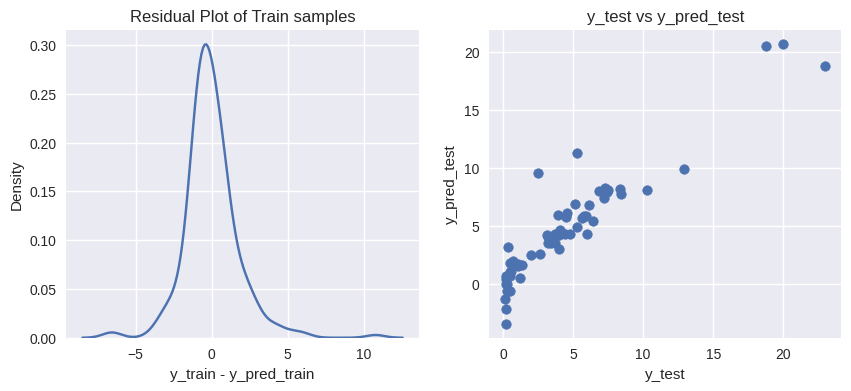

In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
car_pred_model(lr,"Linear_regressor.pkl")

#### Ridge

Train R2-score : 0.88
Test R2-score : 0.86
Train CV scores : [0.89911673 0.8983878  0.82980292 0.81769305 0.71854676]
Train CV mean : 0.83


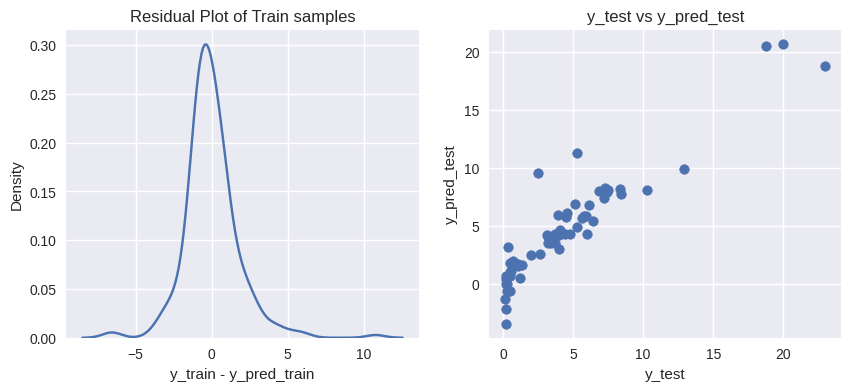

In [31]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

# Creating Ridge model object
rg = Ridge()
# range of alpha
alpha = np.logspace(-3,3,num=14)

# Creating RandomizedSearchCV to find the best estimator of hyperparameter
rg_rs = RandomizedSearchCV(estimator = rg, param_distributions = dict(alpha=alpha))

car_pred_model(rg_rs,"ridge.pkl")

#### Lasso

In [32]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV

ls = Lasso()
alpha = np.logspace(-3,3,num=14) # range for alpha

ls_rs = RandomizedSearchCV(estimator = ls, param_distributions = dict(alpha=alpha))

Train R2-score : 0.88
Test R2-score : 0.87
Train CV scores : [0.89913828 0.90004456 0.8301628  0.81769086 0.70210321]
Train CV mean : 0.83


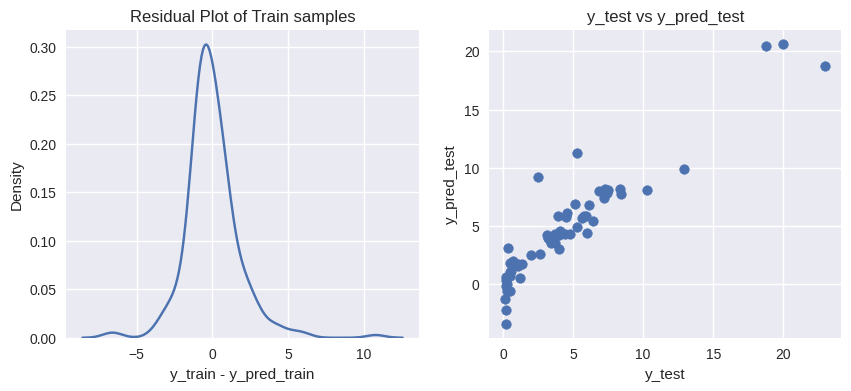

In [33]:
car_pred_model(ls_rs,"lasso.pkl")

#### Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

# Number of trees in Random forest
n_estimators=list(range(500,1000,100))
# Maximum number of levels in a tree
max_depth=list(range(4,9,4))
# Minimum number of samples required to split an internal node
min_samples_split=list(range(4,9,2))
# Minimum number of samples required to be at a leaf node.
min_samples_leaf=[1,2,5,7]
# Number of fearures to be considered at each split
max_features=['auto','sqrt']

# Hyperparameters dict
param_grid = {"n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

rf_rs = RandomizedSearchCV(estimator = rf, param_distributions = param_grid)

Train R2-score : 0.98
Test R2-score : 0.87
Train CV scores : [0.92954723 0.95117346 0.8153129  0.88177609 0.74373867]
Train CV mean : 0.86


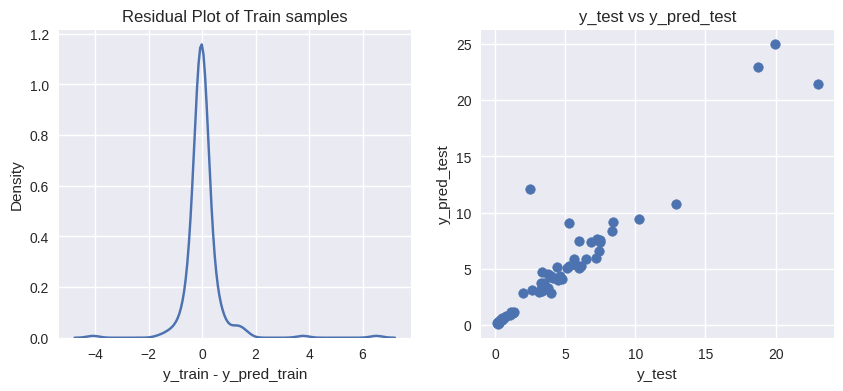

In [35]:
car_pred_model(rf_rs,'random_forest.pkl')

In [36]:
print(rf_rs.best_estimator_)

RandomForestRegressor(max_depth=8, max_features='auto', min_samples_split=4,
                      n_estimators=500)


#### Gradient Boosting

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

gb = GradientBoostingRegressor()

# Rate at which correcting is being made
learning_rate = [0.001, 0.01, 0.1, 0.2]
# Number of trees in Gradient boosting
n_estimators=list(range(500,1000,100))
# Maximum number of levels in a tree
max_depth=list(range(4,9,4))
# Minimum number of samples required to split an internal node
min_samples_split=list(range(4,9,2))
# Minimum number of samples required to be at a leaf node.
min_samples_leaf=[1,2,5,7]
# Number of fearures to be considered at each split
max_features=['auto','sqrt']

# Hyperparameters dict
param_grid = {"learning_rate":learning_rate,
              "n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

gb_rs = RandomizedSearchCV(estimator = gb, param_distributions = param_grid)

Train R2-score : 0.97
Test R2-score : 0.78
Train CV scores : [0.94367548 0.93189264 0.87314343 0.92748279 0.78784408]
Train CV mean : 0.89


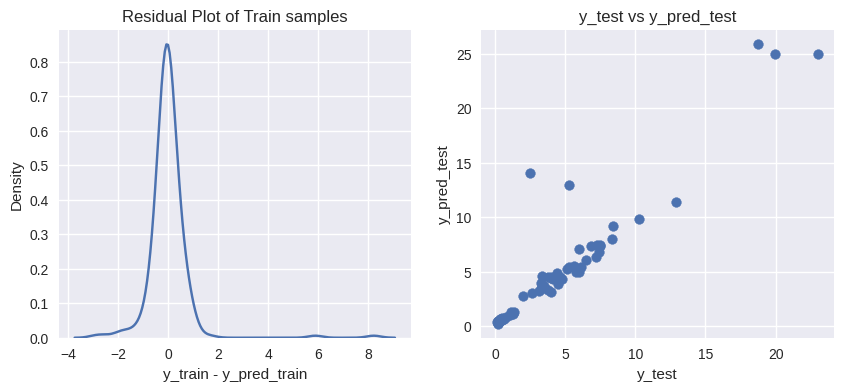

In [38]:
car_pred_model(gb_rs,"gradient_boosting.pkl")

In [39]:
Technique = ["LinearRegression","Ridge","Lasso","RandomForestRegressor","GradientBoostingRegressor"]
results=pd.DataFrame({'Model': Technique,'R Squared(Train)': R2_train,'R Squared(Test)': R2_test,'CV score mean(Train)': CV})
display(results)

,Model,R Squared(Train),R Squared(Test),CV score mean(Train)
0,LinearRegression,0.88,0.86,0.84
1,Ridge,0.88,0.86,0.83
2,Lasso,0.88,0.87,0.83
3,RandomForestRegressor,0.98,0.87,0.86
4,GradientBoostingRegressor,0.97,0.78,0.89
